In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace




In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:
configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

## Load Data

In [8]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [ ]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    
    
    


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



x = preprocess_data(x=x_org, pp="mm")  # only x is standardized




features = dd.features
features







In [ ]:

# df_data_to_use.head()



In [ ]:

# x_org.head()



In [ ]:

# y_org.head()



In [9]:

data_name



'dd_fix_demo'

In [10]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Load new test data

In [11]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data_2_G.xlsx")
print(data_sets_xls.sheet_names)




['demography_test_2', 'fixations_test_2', 'ground_truth']


In [12]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'ground_truth',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
    "Reading speed": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (28, 7)
 


,SubjectID,Sex,Grade,Age,IQ,Group,Reading speed
0,nnr10,1,3,9,25,1,76
1,nnr11,1,3,9,31,3,64
2,nnr2,2,3,9,26,3,62
3,nnr21,2,3,9,29,1,78
4,nnr23,1,3,9,33,1,115


In [65]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test_2',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID", "Sentence_ID",]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()





fix_demo_new = dd.concat_dfs(
            df1=fix_new,
            df2=demo_new,
            features1=fix_new.columns,
            features2=[
                "Sex", "Grade", "Age", "IQ", "Group",
            ],
        )

fix_demo_new

Loading Fix data: 
  (17256, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Group
0,nnr10,4,1,148.1,513.9,293,1,3,9,25,1
1,nnr10,4,2,187.6,527.7,275,1,3,9,25,1
2,nnr10,4,1,158.6,526.2,188,1,3,9,25,1
3,nnr10,4,3,296.9,533.1,144,1,3,9,25,1
4,nnr10,4,3,276.5,534.4,184,1,3,9,25,1
...,...,...,...,...,...,...,...,...,...,...,...
742,nnr91,33,4,541.9,503.0,254,1,2,8,28,1
743,nnr91,33,4,520.2,498.2,191,1,2,8,28,1
744,nnr91,33,4,668.9,480.7,206,1,2,8,28,1
745,nnr91,33,6,969.0,492.4,226,1,2,8,28,1


In [14]:



# # Artificially add rows with missing grades or gender to handle missing values during dummy conversion

# gender_diff = set(df_data_to_use.Sex).difference(set(fix_demo_new.Sex))

# grade_diff = set(df_data_to_use.Grade).difference(set(fix_demo_new.Grade))


# for d in grade_diff:
#     a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
#     fix_demo_new.loc[-1] = a_row
#     fix_demo_new.index = fix_demo_new.index + 1  # shifting index

    


    
# for g in gender_diff:
#     a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
#     fix_demo_new.loc[-1] = a_row
#     fix_demo_new.index = fix_demo_new.index + 1  # shifting index




# grade_diff



In [15]:



# indicators = ["SubjectID", "Sentence_ID", "Word_Number", ]

# fix_demo_new_dum = pd.get_dummies(data=fix_demo_new, columns=c_features)





# fix_demo_new_dum



In [16]:


# # Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
# n_index = len(gender_diff) + len(grade_diff)

# # x_dum_test = fix_stats_demo_new_dum.drop(fix_stats_demo_new_dum.index[-n_index:])
# x_dum_test = fix_demo_new_dum.drop(fix_demo_new_dum.index[-n_index:])
    
# x_dum_test



In [17]:


_ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
demo_phono = dd.concat_classes_demo()

# The optimize way to exclude at-risk class
if to_exclude_at_risk == 1:
    to_exclude_at_risk = True
    demo_phono = demo_phono.loc[demo_phono.Group != 2]

demo_old = demo_phono.loc[:, [
    'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
]]

c_features = ['Sex', 'Grade', ]



Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 


In [18]:



demo_old_norm = demo_old.loc[demo_old.Group == 1]
demo_new_norm = demo_new.loc[demo_new.Group == 1]


demo_old_risk = demo_old.loc[demo_old.Group == 2]
demo_new_risk = demo_new.loc[demo_new.Group == 2]



demo_old_dys = demo_old.loc[demo_old.Group == 3]
demo_new_dys = demo_new.loc[demo_new.Group == 3]




# Data sets comparison 



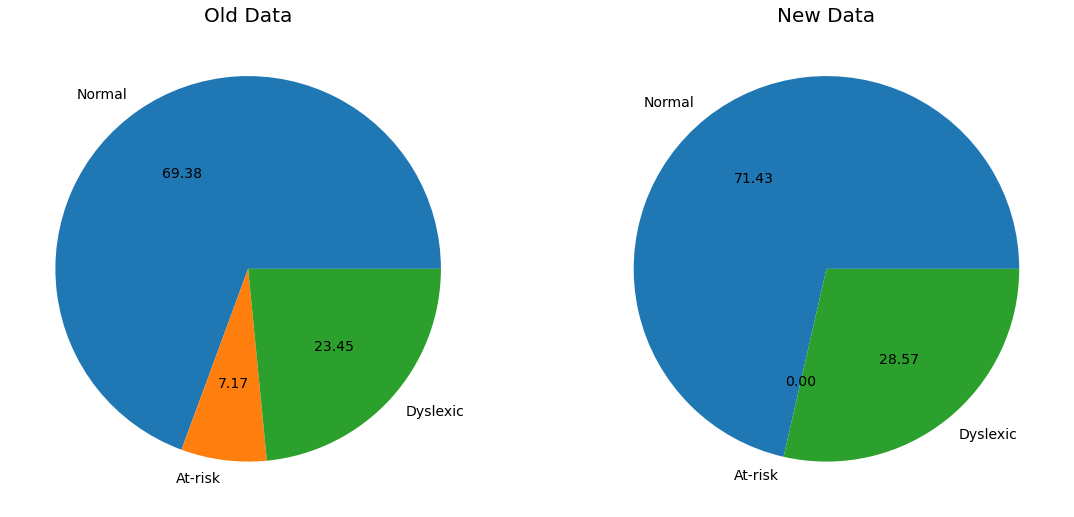

In [19]:


old_demo_stat = [213, 22, 72, ]
new_demo_stat = [demo_new_norm.shape[0], demo_new_risk.shape[0], demo_new_dys.shape[0], ]


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 2, 1)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=old_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Data', fontsize=20)


ax = fig.add_subplot(1, 2, 2)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=new_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Data', fontsize=20)


plt.show()




In [20]:

genders = [1, 2]

gender_old = [len(demo_old['Sex'].loc[demo_old['Sex']==f]) for f in genders]
gender_new = [len(demo_new['Sex'].loc[demo_new['Sex']==f]) for f in genders]


gender_old_dys = [len(demo_old_dys['Sex'].loc[demo_old_dys['Sex']==f]) for f in genders]
gender_new_dys = [len(demo_new_dys['Sex'].loc[demo_new_dys['Sex']==f]) for f in genders]




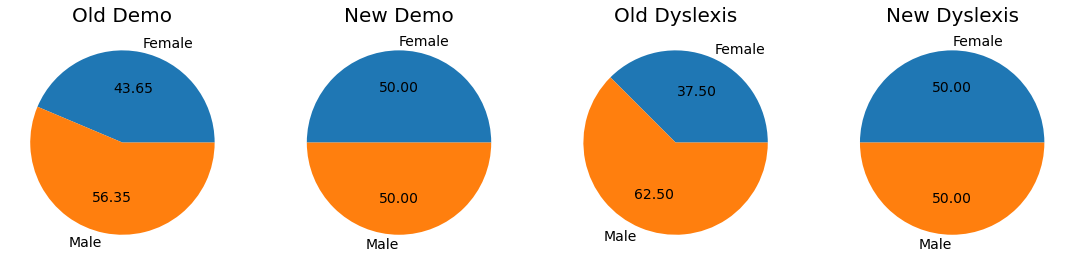

In [21]:


fig = plt.figure(figsize=(19, 13))



ax = fig.add_subplot(1, 4, 1)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Demo', fontsize=20)


ax = fig.add_subplot(1, 4, 2)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Demo', fontsize=20)



ax = fig.add_subplot(1, 4, 3)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Dyslexis', fontsize=20)


ax = fig.add_subplot(1, 4, 4)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexis', fontsize=20)

plt.show()



In [25]:



gender_old_norm = [len(demo_old_norm['Sex'].loc[demo_old_norm['Sex']==f]) for f in [1, 2]]
gender_new_norm = [len(demo_new_norm['Sex'].loc[demo_new_norm['Sex']==f]) for f in [1, 2]]


gender_old_risk = [len(demo_old_risk['Sex'].loc[demo_old_risk['Sex']==f]) for f in [1, 2]]
gender_new_risk = [len(demo_new_risk['Sex'].loc[demo_new_risk['Sex']==f]) for f in [1, 2]]






normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


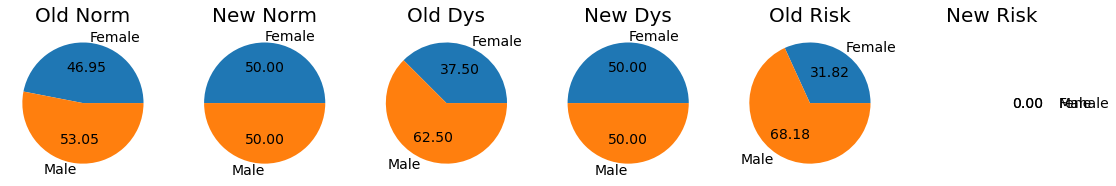

In [32]:


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 6, 1)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_norm, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Norm', fontsize=20)


ax = fig.add_subplot(1, 6, 2)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_norm, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}
)

plt.title('New Norm', fontsize=20)


ax = fig.add_subplot(1, 6, 3)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Dys', fontsize=20)


ax = fig.add_subplot(1, 6, 4)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dys', fontsize=20)

ax = fig.add_subplot(1, 6, 5)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_risk, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Risk', fontsize=20)


ax = fig.add_subplot(1, 6, 6)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_risk, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Risk', fontsize=20)



plt.show()



In [38]:


grades = [1, 2, 3, 4, 5, 6]


grades_old = [len(demo_old['Grade'].loc[demo_old['Grade']==f]) for f in grades]
grades_new = [len(demo_new['Grade'].loc[demo_new['Grade']==f]) for f in grades]

grades_old_norm = [len(demo_old_norm['Grade'].loc[demo_old_norm['Grade']==f]) for f in grades]
grades_new_norm = [len(demo_new_norm['Grade'].loc[demo_new_norm['Grade']==f]) for f in grades]


grades_old_dys = [len(demo_old_dys['Grade'].loc[demo_old_dys['Grade']==f]) for f in grades]
grades_new_dys = [len(demo_new_dys['Grade'].loc[demo_new_dys['Grade']==f]) for f in grades]




In [43]:


grades_new_dys


[0, 1, 6, 1, 0, 0]

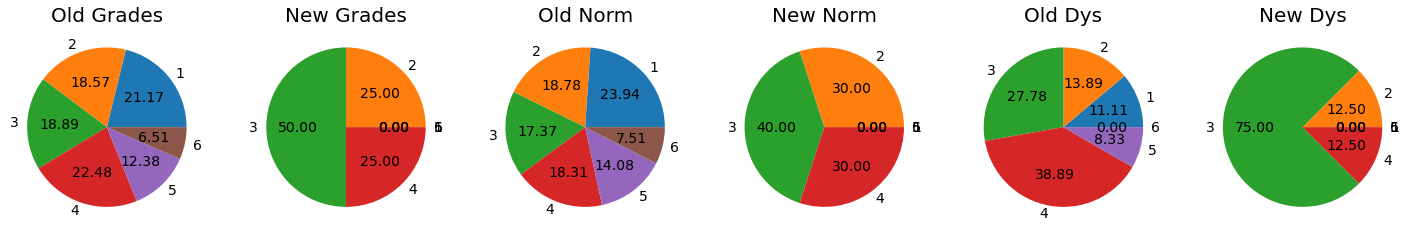

In [54]:





fig = plt.figure(figsize=(25, 15))


ax = fig.add_subplot(1, 6, 1)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_old, 
    labels=['1', '2', '3', '4', '5', '6'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Grades', fontsize=20)

ax = fig.add_subplot(1, 6, 2)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_new, 
    labels=['1', '2', '3', '4', '5', '6'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Grades', fontsize=20)


ax = fig.add_subplot(1, 6, 3)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_old_norm, 
    labels=['1', '2', '3', '4', '5', '6'],
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Norm', fontsize=20)


ax = fig.add_subplot(1, 6, 4)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_new_norm, 
    labels=['1', '2', '3', '4', '5', '6'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}
)

plt.title('New Norm', fontsize=20)


ax = fig.add_subplot(1, 6, 5)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_old_dys, 
    labels=['1', '2', '3', '4', '5', '6'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Dys', fontsize=20)


ax = fig.add_subplot(1, 6, 6)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_new_dys, 
    labels=['1', '2', '3', '4', '5', '6'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dys', fontsize=20)



plt.show()






In [60]:
grades_old_dys, grades_new_dys

([8, 10, 20, 28, 6, 0], [0, 1, 6, 1, 0, 0])

# Fixation data sets comparison



In [70]:


grade_3_old = fix_demo.loc[fix_demo.Grade == 3]
grade_3_old_norm = grade_3_old.loc[grade_3_old.Group == 1]
grade_3_old_dys = grade_3_old.loc[grade_3_old.Group == 3]




In [80]:

grade_3_new = fix_demo_new.loc[fix_demo_new.Grade == 3]
grade_3_new_norm = grade_3_new.loc[grade_3_new.Group == 1]
grade_3_new_dys = grade_3_new.loc[grade_3_new.Group == 3]





In [83]:
fix_demo

,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...
511,3,zrs09,33,5,743.3,562.7,160.0,2,3,10,32,97.0
512,3,zrs09,33,5,772.5,555.8,193.0,2,3,10,32,97.0
513,3,zrs09,33,5,941.7,561.9,219.0,2,3,10,32,97.0
514,3,zrs09,33,5,831.8,548.8,144.0,2,3,10,32,97.0


In [89]:

features_to_show = ["FIX_X", "FIX_Y", "FIX_DURATION", 'Sex', 'Age', 'IQ']
grade_3_old_norm.loc[:, features_to_show].describe()



,FIX_X,FIX_Y,FIX_DURATION,Sex,Age,IQ
count,23944.000000,23944.000000,23944.000000,23944.000000,23944.000000,23944.000000
mean,618.611523,538.654987,221.306465,1.502840,9.265662,31.331231
std,298.598718,27.044846,140.807049,0.500002,0.441694,3.496515
min,120.200000,333.300000,1.000000,1.000000,9.000000,21.000000
25%,365.500000,522.400000,145.000000,1.000000,9.000000,30.000000
50%,594.700000,537.100000,196.000000,2.000000,9.000000,32.000000
75%,865.600000,553.600000,274.000000,2.000000,10.000000,34.000000
max,1419.400000,725.100000,4190.000000,2.000000,10.000000,35.000000


In [90]:

grade_3_new_norm.loc[:, features_to_show].describe()


,FIX_X,FIX_Y,FIX_DURATION,Sex,Age,IQ
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000
mean,614.506134,542.875267,251.711853,1.553809,8.886269,29.847413
std,298.487786,20.473253,137.637142,0.497150,0.317518,2.594011
min,122.200000,429.800000,7.000000,1.000000,8.000000,25.000000
25%,362.100000,528.100000,164.000000,1.000000,9.000000,29.000000
50%,591.300000,542.100000,218.000000,2.000000,9.000000,31.000000
75%,860.400000,557.600000,299.000000,2.000000,9.000000,32.000000
max,1424.500000,709.200000,1948.000000,2.000000,9.000000,33.000000


In [93]:


grade_3_old_dys.loc[:, features_to_show].describe()



,FIX_X,FIX_Y,FIX_DURATION,Sex,Age,IQ
count,15947.000000,15947.000000,15947.000000,15947.000000,15947.000000,15947.000000
mean,625.939412,533.768025,327.457516,1.374052,9.258481,32.014548
std,303.669384,21.410725,208.624760,0.483892,0.542820,5.171877
min,120.000000,480.000000,1.000000,1.000000,8.000000,15.000000
25%,365.200000,520.000000,193.000000,1.000000,9.000000,31.000000
50%,605.000000,535.100000,268.000000,1.000000,9.000000,34.000000
75%,873.650000,550.200000,399.500000,2.000000,10.000000,35.000000
max,1464.000000,574.900000,3344.000000,2.000000,10.000000,36.000000


In [94]:


grade_3_new_dys.loc[:, features_to_show].describe()



,FIX_X,FIX_Y,FIX_DURATION,Sex,Age,IQ
count,4737.000000,4737.000000,4737.000000,4737.000000,4737.0,4737.000000
mean,613.754803,538.868778,296.841461,1.506439,9.0,28.240025
std,298.080138,22.851673,170.987196,0.500011,0.0,2.731900
min,120.000000,342.300000,2.000000,1.000000,9.0,24.000000
25%,357.300000,521.400000,181.000000,1.000000,9.0,26.000000
50%,588.500000,541.700000,245.000000,2.000000,9.0,29.000000
75%,864.200000,553.800000,372.000000,2.000000,9.0,31.000000
max,1410.300000,668.200000,1777.000000,2.000000,9.0,32.000000
